# Hofstadter's Butterfly Code
By Shrikar Dulam, Sarah Wang, Hyeonsu Kang, Juwon Bae 

In [22]:
# Neccessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh
import matplotlib.colors as colors
from matplotlib.animation import FuncAnimation
import pandas as pd

# Helper Functions for Chern Number Computations

In [23]:
def gcd(a, b):
    while b:
        a, b = b, a % b
    return a

def extended_gcd(a, b):
    """Extended Euclidean algorithm"""
    if a == 0:
        return b, 0, 1
    gcd_val, x1, y1 = extended_gcd(b % a, a)
    x = y1 - (b // a) * x1
    y = x1
    return gcd_val, x, y

def solve_diophantine(r, q, p):
    """
    Solve the linear Diophantine equation: r = q*s_r + p*t_r
    with constraint |t_r| <= q/2
    """
    g = gcd(q, p)
    if r % g != 0:
        return None
    
    # Scale down the equation
    q_scaled = q // g
    p_scaled = p // g
    r_scaled = r // g
    
    # Find particular solution using extended GCD
    gcd_val, s0, t0 = extended_gcd(q_scaled, p_scaled)
    
    # Particular solution
    s_particular = s0 * r_scaled
    t_particular = t0 * r_scaled
    
    # General solution: s = s_particular + k*p_scaled, t = t_particular - k*q_scaled
    # We want |t| <= q/2, so |t_particular - k*q_scaled| <= q/2
    
    best_k = 0
    best_t = t_particular
    
    # Search for k that minimizes |t| and satisfies |t| <= q/2
    for k in range(-q, q+1):
        t_candidate = t_particular - k * q_scaled
        if abs(t_candidate) <= q // 2:
            if abs(t_candidate) < abs(best_t):
                best_k = k
                best_t = t_candidate
    
    s_r = s_particular + best_k * p_scaled
    t_r = best_t
    
    return (s_r, t_r)

def compute_chern_numbers_tknn(p, q):
    """
    Compute Chern numbers using TKNN method
    """
    if gcd(p, q) != 1 and p != 0:
        # Reduce fraction
        g = gcd(p, q)
        p, q = p // g, q // g
    
    diophantine_solutions = []
    chern_numbers = []
    
    # Solve Diophantine equation for each band r = 1, 2, ..., q
    for r in range(1, q + 1):
        solution = solve_diophantine(r, q, p)
        if solution:
            s_r, t_r = solution
            diophantine_solutions.append((s_r, t_r))
        else:
            diophantine_solutions.append((0, 0))
    
    # Compute Chern numbers: C_r = t_r - t_{r-1} with t_0 = 0
    t_prev = 0
    for s_r, t_r in diophantine_solutions:
        C_r = t_r - t_prev
        chern_numbers.append(C_r)
        t_prev = t_r
    
    return chern_numbers, diophantine_solutions


# Hamiltonian Matrices

In [24]:
# The Hamiltonian for the square lattice which will be diagonalized to obtain the energy spectrum
# Function of flux p/q and optionally wavenumbers and interaction energy 

def hofstadter_hamiltonian(p, q, k_x=0, k_y=0, t=1.0):
    H = np.zeros((q, q), dtype=complex)
    
    for j in range(q):
        # Hopping in x-direction (some phase based on momentum)
        H[j, (j + 1) % q] += t * np.exp(1j * k_x)
        H[(j + 1) % q, j] += t * np.exp(-1j * k_x)
        
        # Hopping in y-direction with magnetic phase
        phase_y = 2 * np.pi * p * j / q - k_y
        H[j, j] += 2 * t * np.cos(phase_y)
    
    return H

# For Hall conductance, otherwise some weird issue occurs when the wings don't fully display. 
def harper_hamiltonian(p, q, k_x=0, k_y=0, t=1.0):
    H = np.zeros((q, q), dtype=complex)
    for m in range(q):
        # Diagonal (onsite potential)
        H[m, m] = 2 * t * np.cos(2 * np.pi * p * m / q - k_y)
        # Hopping terms (nearest neighbor)
        H[m, (m + 1) % q] = -t
        H[(m + 1) % q, m] = -t

    return H

# The Hamiltonian for the hexagonal lattice based on Rammal's paper
def hexagonal_butterfly_hamiltonian(p, q, k_y=0, k_x=0, a=1):
    H = np.zeros((q, q), dtype=complex)
    kappa = k_y * a * np.sqrt(3)/2
    for m in range(q):
        # Periodic boundary conditions (mod q)
        mp1 = (m + 1) % q
        mm1 = (m - 1) % q

        # Matrix elements prescribed by paper 
        H[m, mp1] = 2 * np.cos(-np.pi * p / q * (m + 0.5) + kappa)
        H[m, mm1] = 2 * np.cos(-np.pi * p / q * (m - 0.5) + kappa)
        H[m, m]   = 2 * np.cos(-2 * np.pi * p / q * (m + 0.5) + 2 * kappa)
    
    return H

# Primary Computation/Plotting Functions

In [25]:
def compute_butterfly_with_chern(max_q=30):
    """
    Compute spectrum with proper TKNN Chern numbers
    """
    butterfly_data = []
    
    for q in range(1, max_q + 1):
        for p in range(1, q + 1):
            if gcd(p, q) == 1:
                flux = p / q
                
                # Compute energy spectrum
                H = hofstadter_hamiltonian(p, q)
                eigenvals = np.sort(eigh(H, eigvals_only=True))
                
                # Compute Chern numbers using TKNN method
                chern_numbers, diophantine_sols = compute_chern_numbers_tknn(p, q)
                
                # Store data for each band
                for band_idx, (energy, chern) in enumerate(zip(eigenvals, chern_numbers)):
                    butterfly_data.append({
                        'flux': flux,
                        'energy': energy,
                        'chern': chern,
                        'band': band_idx,
                        'p': p,
                        'q': q
                    })
    
    return butterfly_data

def compute_hall_conductivity(p, q, fermi_energy):
    """
    Compute Hall conductivity for given Fermi energy
    """
    # Get energy spectrum and Chern numbers
    #H = hofstadter_hamiltonian(p,q)
    H = harper_hamiltonian(p,q)
    
    eigenvals = np.sort(eigh(H, eigvals_only=True))
    chern_numbers, _ = compute_chern_numbers_tknn(p, q)
    
    # Find filled bands (E < E_F)
    filled_bands = eigenvals < fermi_energy
    
    # Hall conductivity is sum of Chern numbers of filled bands
    # σ_xy = (e²/2πℏ) * Σ C_r for filled bands
    hall_conductivity = sum(C for C, filled in zip(chern_numbers, filled_bands) if filled)
    
    return hall_conductivity

def plot_basic_butterfly(bdata, save_path=None, dpi=300):
    """
    Plots only the energy spectrum
    """
    # Extract data
    flux_vals = [d['flux'] for d in bdata]
    energies = [d['energy'] for d in bdata]
    chern_nums = [d['chern'] for d in bdata]
        
     # Create figure
    fig, ax = plt.subplots(figsize=(12, 8), dpi=dpi)

    # Plot
    scatter = ax.scatter(flux_vals, energies, s=0.5)

    # Labels and appearance
    ax.set_xlabel('Magnetic Flux (Φ/Φ₀)', fontsize=14)
    ax.set_ylabel('Energy / t', fontsize=14)
    ax.set_title('Hofstadter Butterfly - Energy Spectrum', fontsize=16)
    ax.grid(True, alpha=0.3)

    # Optional save
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight')

    plt.show()
    

def plot_chern_butterfly(bdata, save_path=None, dpi=300): 
    """
    Plots colored energy spectrum based on TKNN Chern number
    """
    flux_vals = [d['flux'] for d in bdata]
    energies = [d['energy'] for d in bdata]
    chern_nums = [d['chern'] for d in bdata]
    
    chern_min, chern_max = min(chern_nums), max(chern_nums)
    norm = colors.Normalize(vmin=chern_min, vmax=chern_max)

     # Create figure
    fig, ax = plt.subplots(figsize=(12, 8), dpi=dpi)
    
    scatter2 = plt.scatter(flux_vals, energies, c=chern_nums,
                          cmap='RdBu_r', s=1.5, alpha=0.8, norm=norm)
    ax.set_xlabel('Magnetic Flux (Φ/Φ₀)')
    ax.set_ylabel('Energy/t')
    ax.set_title('Hofstadter Butterfly - TKNN Chern Numbers')
    ax.grid(True, alpha=0.3)
    
    cbar2 = plt.colorbar(scatter2, ax=ax, label='Chern Number')
    if chern_max - chern_min <= 20:  # Only show integer ticks if reasonable range
        cbar2.set_ticks(range(chern_min, chern_max + 1))

    plt.show()

def plot_hall_conduct(bdata, save_path=None, dpi=300): 
    """
    Sums TKNN Chern number of bands to compute overall Hall conductivity
    """
    flux_vals = [d['flux'] for d in bdata]
    energies = [d['energy'] for d in bdata]
    chern_nums = [d['chern'] for d in bdata]
    
    hall_conductivities = []
    flux_grid = []
    energy_grid = []
    
    for d in bdata:
        hall_cond = compute_hall_conductivity(d['p'], d['q'], d['energy'])
        hall_conductivities.append(hall_cond)
        flux_grid.append(d['flux'])
        energy_grid.append(d['energy'])

     # Create figure
    fig, ax = plt.subplots(figsize=(12, 8), dpi=dpi)

    scatter3 = plt.scatter(flux_grid, energy_grid, c=hall_conductivities,
                          cmap='seismic', s=1.5, alpha=0.8)
    ax.set_xlabel('Magnetic Flux (Φ/Φ₀)')
    ax.set_ylabel('Energy/t')
    ax.set_title('Hall Conductivity (σₓᵧ in units of e²/2πℏ)')
    ax.grid(True, alpha=0.3)
    plt.colorbar(scatter3, ax=ax, label='σₓᵧ/(e²/2πℏ)')
    plt.show()

def plot_chern_histogram(bdata):  
    """
    Displays distribution of Chern numbers
    """
    flux_vals = [d['flux'] for d in bdata]
    energies = [d['energy'] for d in bdata]
    chern_nums = [d['chern'] for d in bdata]
    unique_cherns, counts = np.unique(chern_nums, return_counts=True)
    plt.bar(unique_cherns, counts, alpha=0.7, color='skyblue', edgecolor='navy')
    plt.xlabel('Chern Number')
    plt.ylabel('Frequency')
    plt.title('Distribution of Chern Numbers')
    plt.grid(True, alpha=0.3)
    plt.show()

def compute_honeycomb(max_q=30):
    """
    Calculates hexagonal energy spectrum 
    """
    butterfly_data = []
    
    for q in range(1, max_q + 1):
        for p in range(1, q + 1):
            if gcd(p, q) == 1:
                flux = p / q
                
                H = hexagonal_butterfly_hamiltonian(p, q)
                
                eigenvals = np.sort(eigh(H, eigvals_only=True))
                real_energies = []
                for i in eigenvals: 
                    real_energies.append(np.sqrt(i+3))
                    real_energies.append(-np.sqrt(i+3))
                    
                
                # Store data for each band
                for _, energy in enumerate(real_energies):
                    butterfly_data.append({
                        'flux': flux,
                        'energy': energy,
                    })
    
    return butterfly_data

def plot_honeycomb_butterfly(bdata, save_path="honeycomb_butterfly.png", dpi=100):
    """
    Displays hexagonal energy spectrum 
    """
    
    # Extract data
    flux_vals = [d['flux'] for d in bdata]
    energies = [d['energy'] for d in bdata]
        
    fig, ax = plt.subplots(figsize=(12, 8), dpi=dpi)
    scatter = ax.scatter(flux_vals, energies, s=0.5)

    # Labels and appearance
    ax.set_xlabel('Magnetic Flux (Φ/Φ₀)', fontsize=14)
    ax.set_ylabel('Energy / t', fontsize=14)
    ax.set_title('Honeycomb Lattice Butterfly', fontsize=16)
    ax.grid(True, alpha=0.3)

    # Optional save
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight')

    plt.show()

# Visual Analysis for specific $\alpha$

In [26]:
def analyze_alpha(p, q):
    chern_numbers, diophantine_sols = compute_chern_numbers_tknn(p, q)

    # Compute and display energy spectrum
    H = hofstadter_hamiltonian(p, q)
    eigenvals = np.sort(eigh(H, eigvals_only=True))
    
    # Plot the example
    fig = plt.figure(figsize=(12, 10))

    # Use a 2x2 grid:
    ax1 = plt.subplot2grid((2, 2), (0, 0))  # Top-left
    ax2 = plt.subplot2grid((2, 2), (0, 1))  # Top-right
    ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2)  # Bottom row spans both columns
    
    # Energy levels with Chern numbers
    colors_chern = plt.cm.RdBu_r(np.linspace(0, 1, len(set(chern_numbers))))
    chern_to_color = {c: colors_chern[i] for i, c in enumerate(sorted(set(chern_numbers)))}
    
    for i, (E, C) in enumerate(zip(eigenvals, chern_numbers)):
        ax1.barh(i, 1, height=0.8, left=E, alpha=0.7, 
                color=chern_to_color[C], edgecolor='black')
        ax1.text(E + 0.1, i, f'C={C}', va='center', fontsize=10, fontweight='bold')
    
    ax1.set_xlabel('Energy/t')
    ax1.set_ylabel('Band Index')
    ax1.set_title(f'Energy Bands for Φ/Φ₀ = {p}/{q}')
    ax1.grid(True, alpha=0.3)
    
    # Hall conductivity vs Fermi energy
    E_fermi = np.linspace(eigenvals.min() - 1, eigenvals.max() + 1, 1000)
    sigma_xy = []
    
    for E_F in E_fermi:
        sigma = compute_hall_conductivity(p, q, E_F)
        sigma_xy.append(sigma)
    
    ax2.plot(E_fermi, sigma_xy, 'b-', linewidth=2)
    ax2.axhline(y=0, color='k', linestyle='--', alpha=0.5)
    for E in eigenvals:
        ax2.axvline(x=E, color='r', linestyle=':', alpha=0.7)
    
    ax2.set_xlabel('Fermi Energy/t')
    ax2.set_ylabel('σₓᵧ/(e²/2πℏ)')
    ax2.set_title(f'Hall Conductivity vs Fermi Energy')
    ax2.grid(True, alpha=0.3)

    # Bands vs ky plot
    kys = np.linspace(-np.pi, np.pi, 400)
    for ky in kys:
        Hk = hofstadter_hamiltonian(p, q, k_y=ky)
        energies = np.linalg.eigvalsh(Hk)
        ax3.plot([ky]*q, energies, 'k.', markersize=1)

    ax3.set_xlabel('$k_y$')
    ax3.set_ylabel('Energy/t')
    ax3.set_title(f'Band Structure vs $k_y$ for Φ/Φ₀ = {p}/{q}')
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()

    plt.savefig("AlphaAnalysis.png", dpi=100, bbox_inches='tight')
    plt.show()

# Main Graphs 

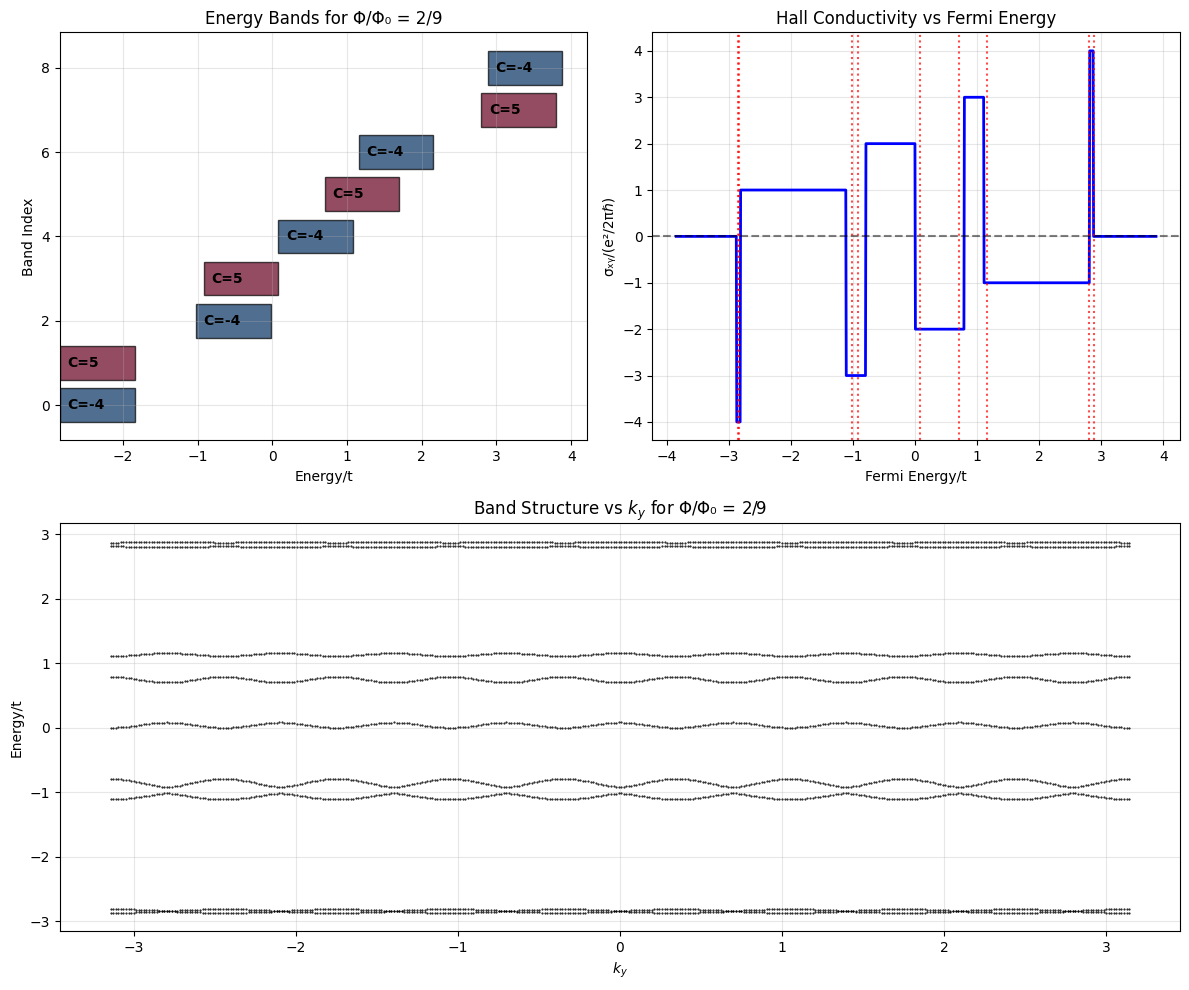

In [6]:
analyze_alpha(2, 9)

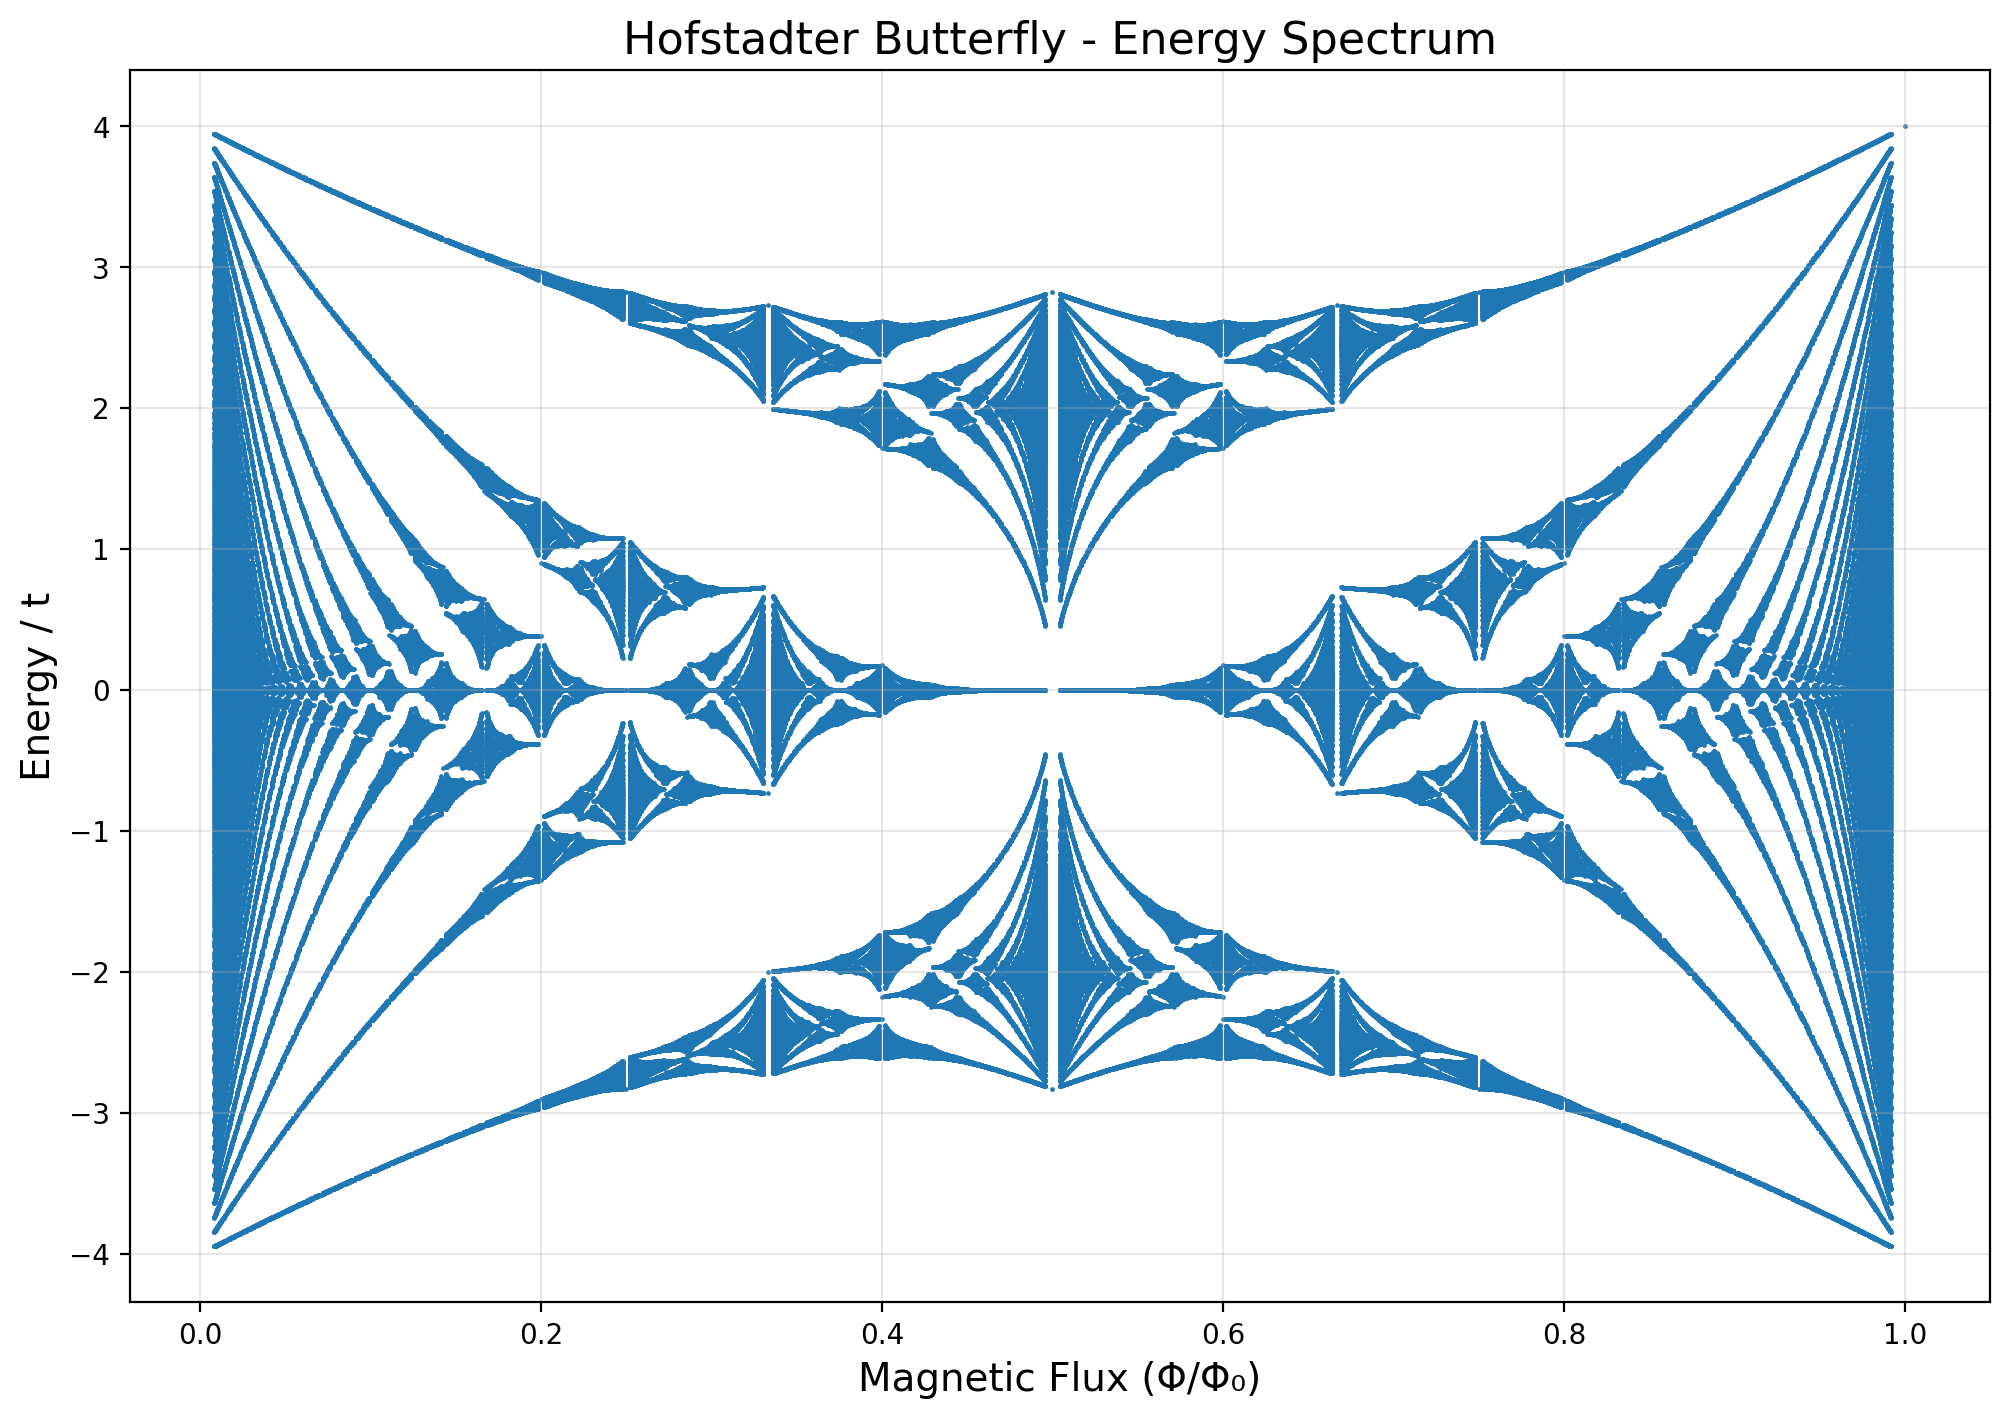

In [7]:
ndata = compute_butterfly_with_chern(max_q=120)
plot_basic_butterfly(ndata, save_path="normalbutterfly.png", dpi=200)

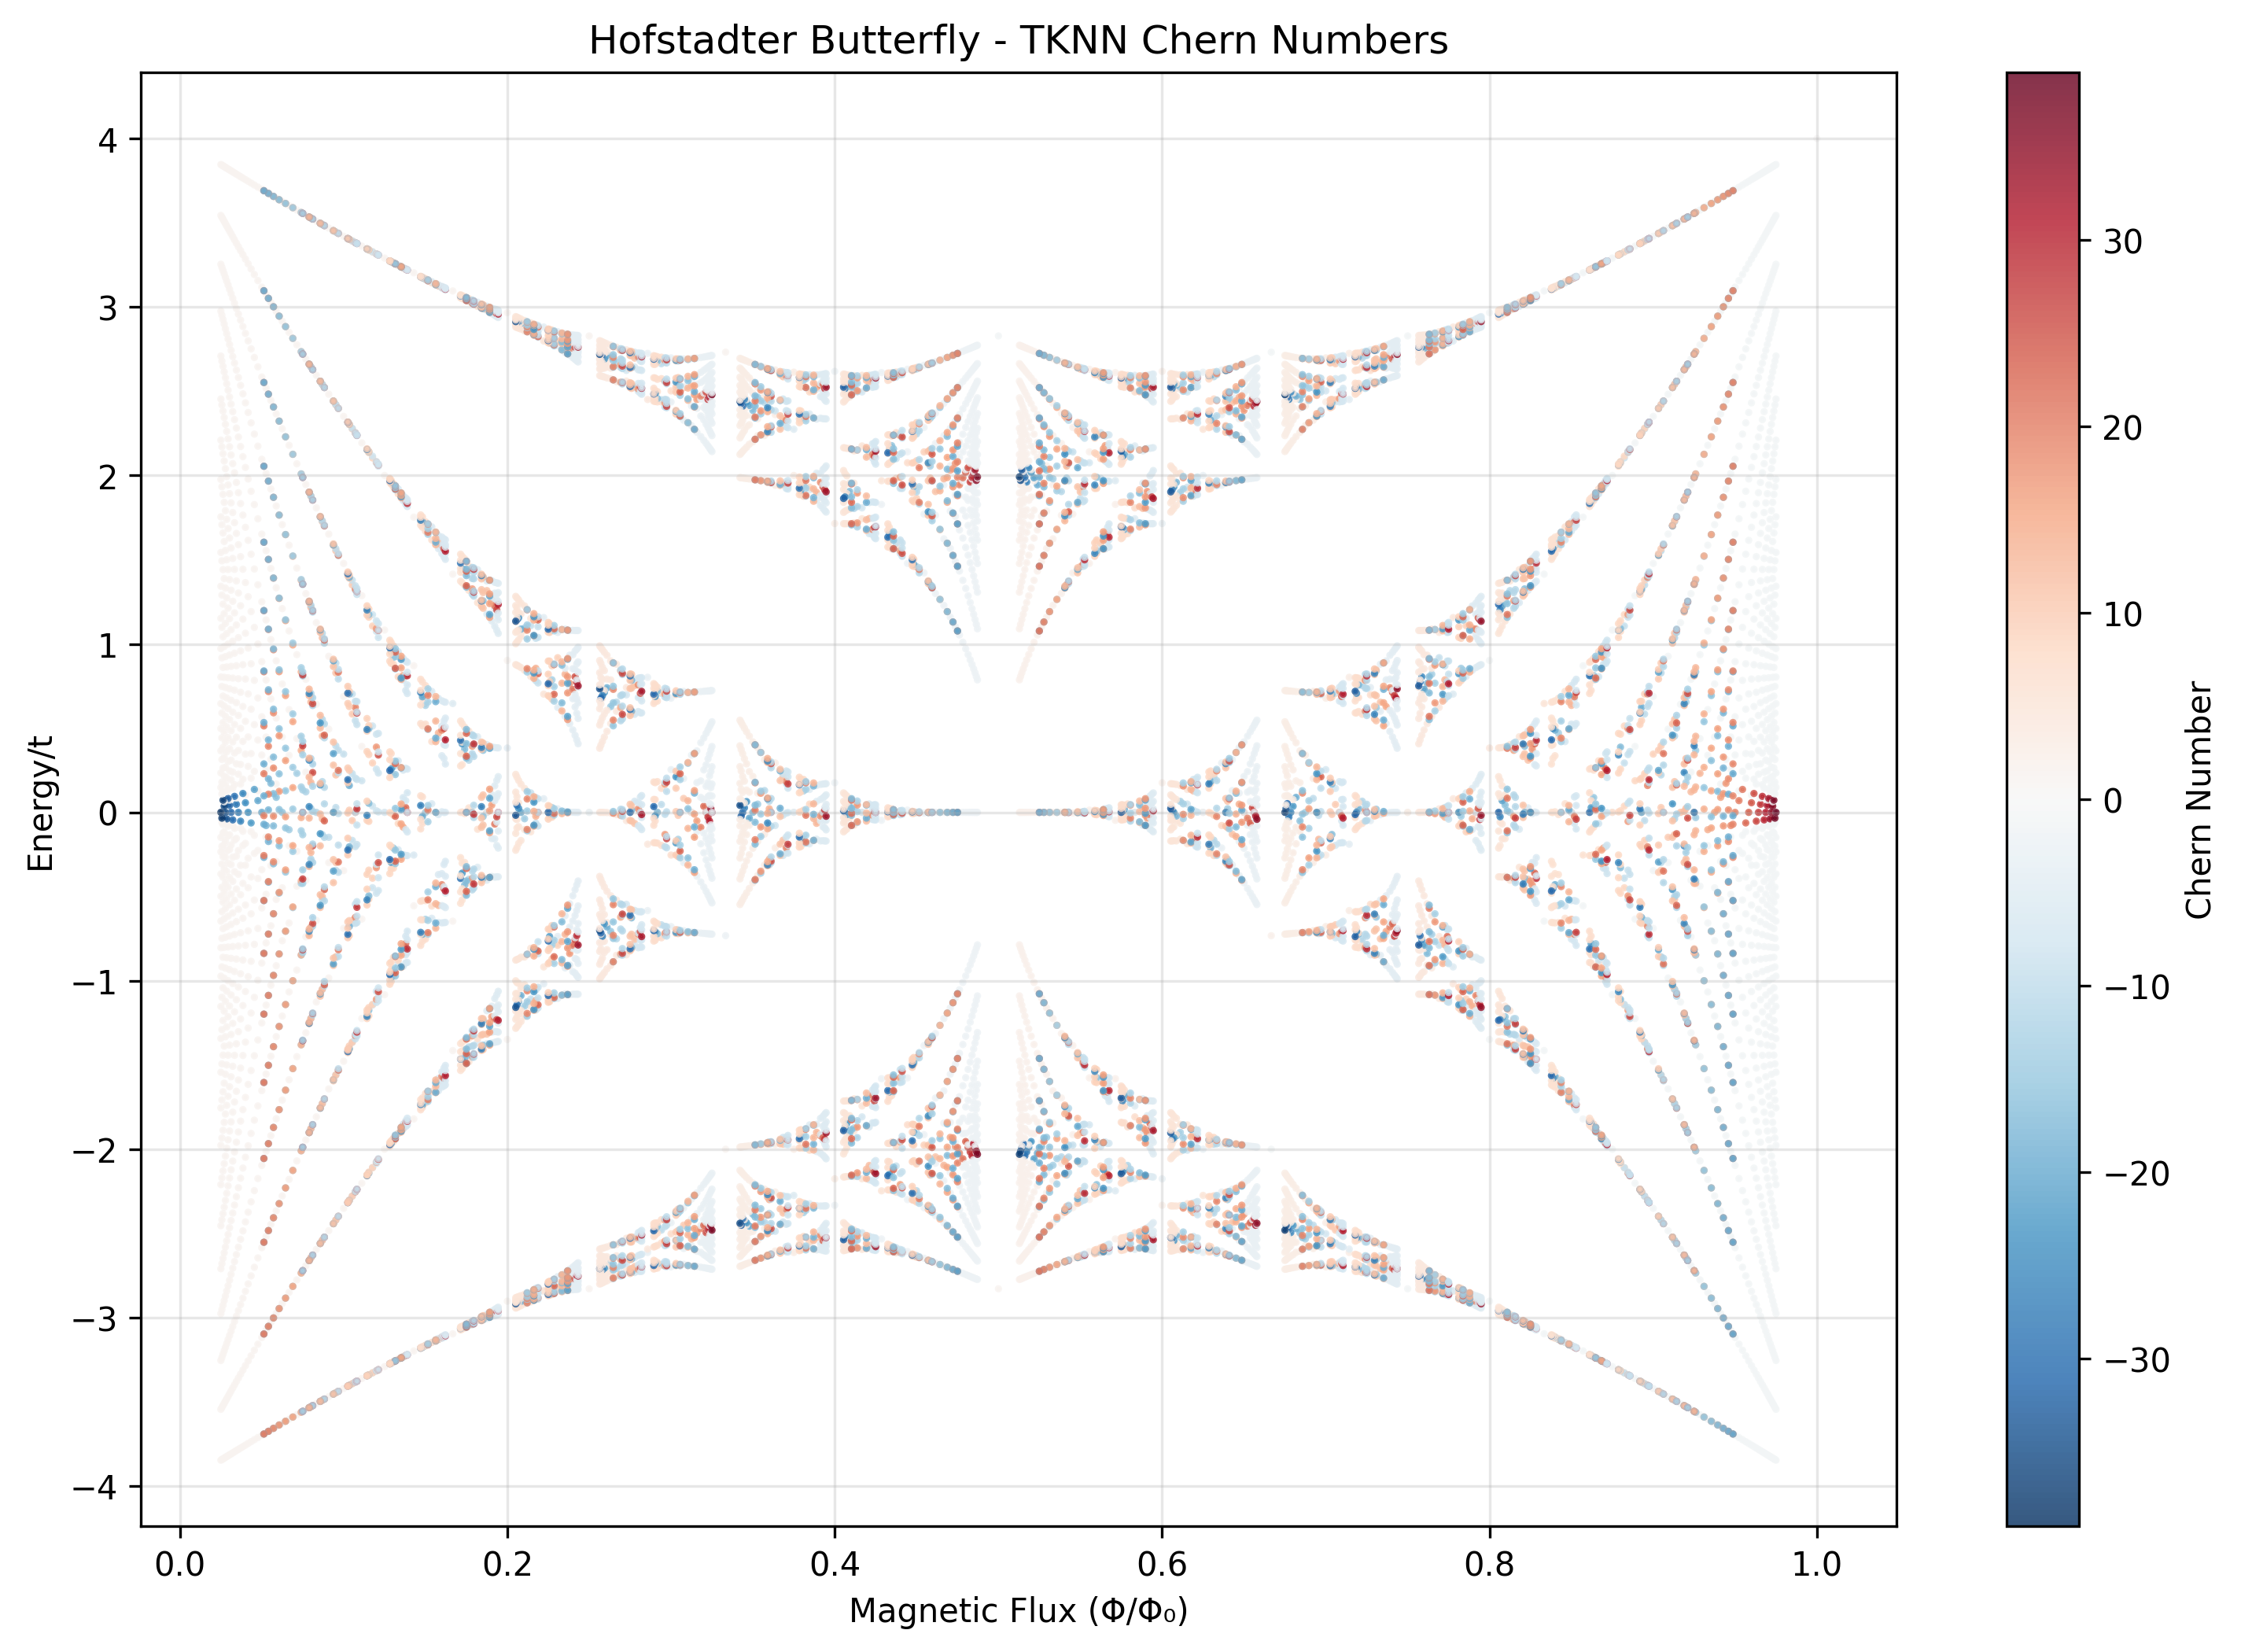

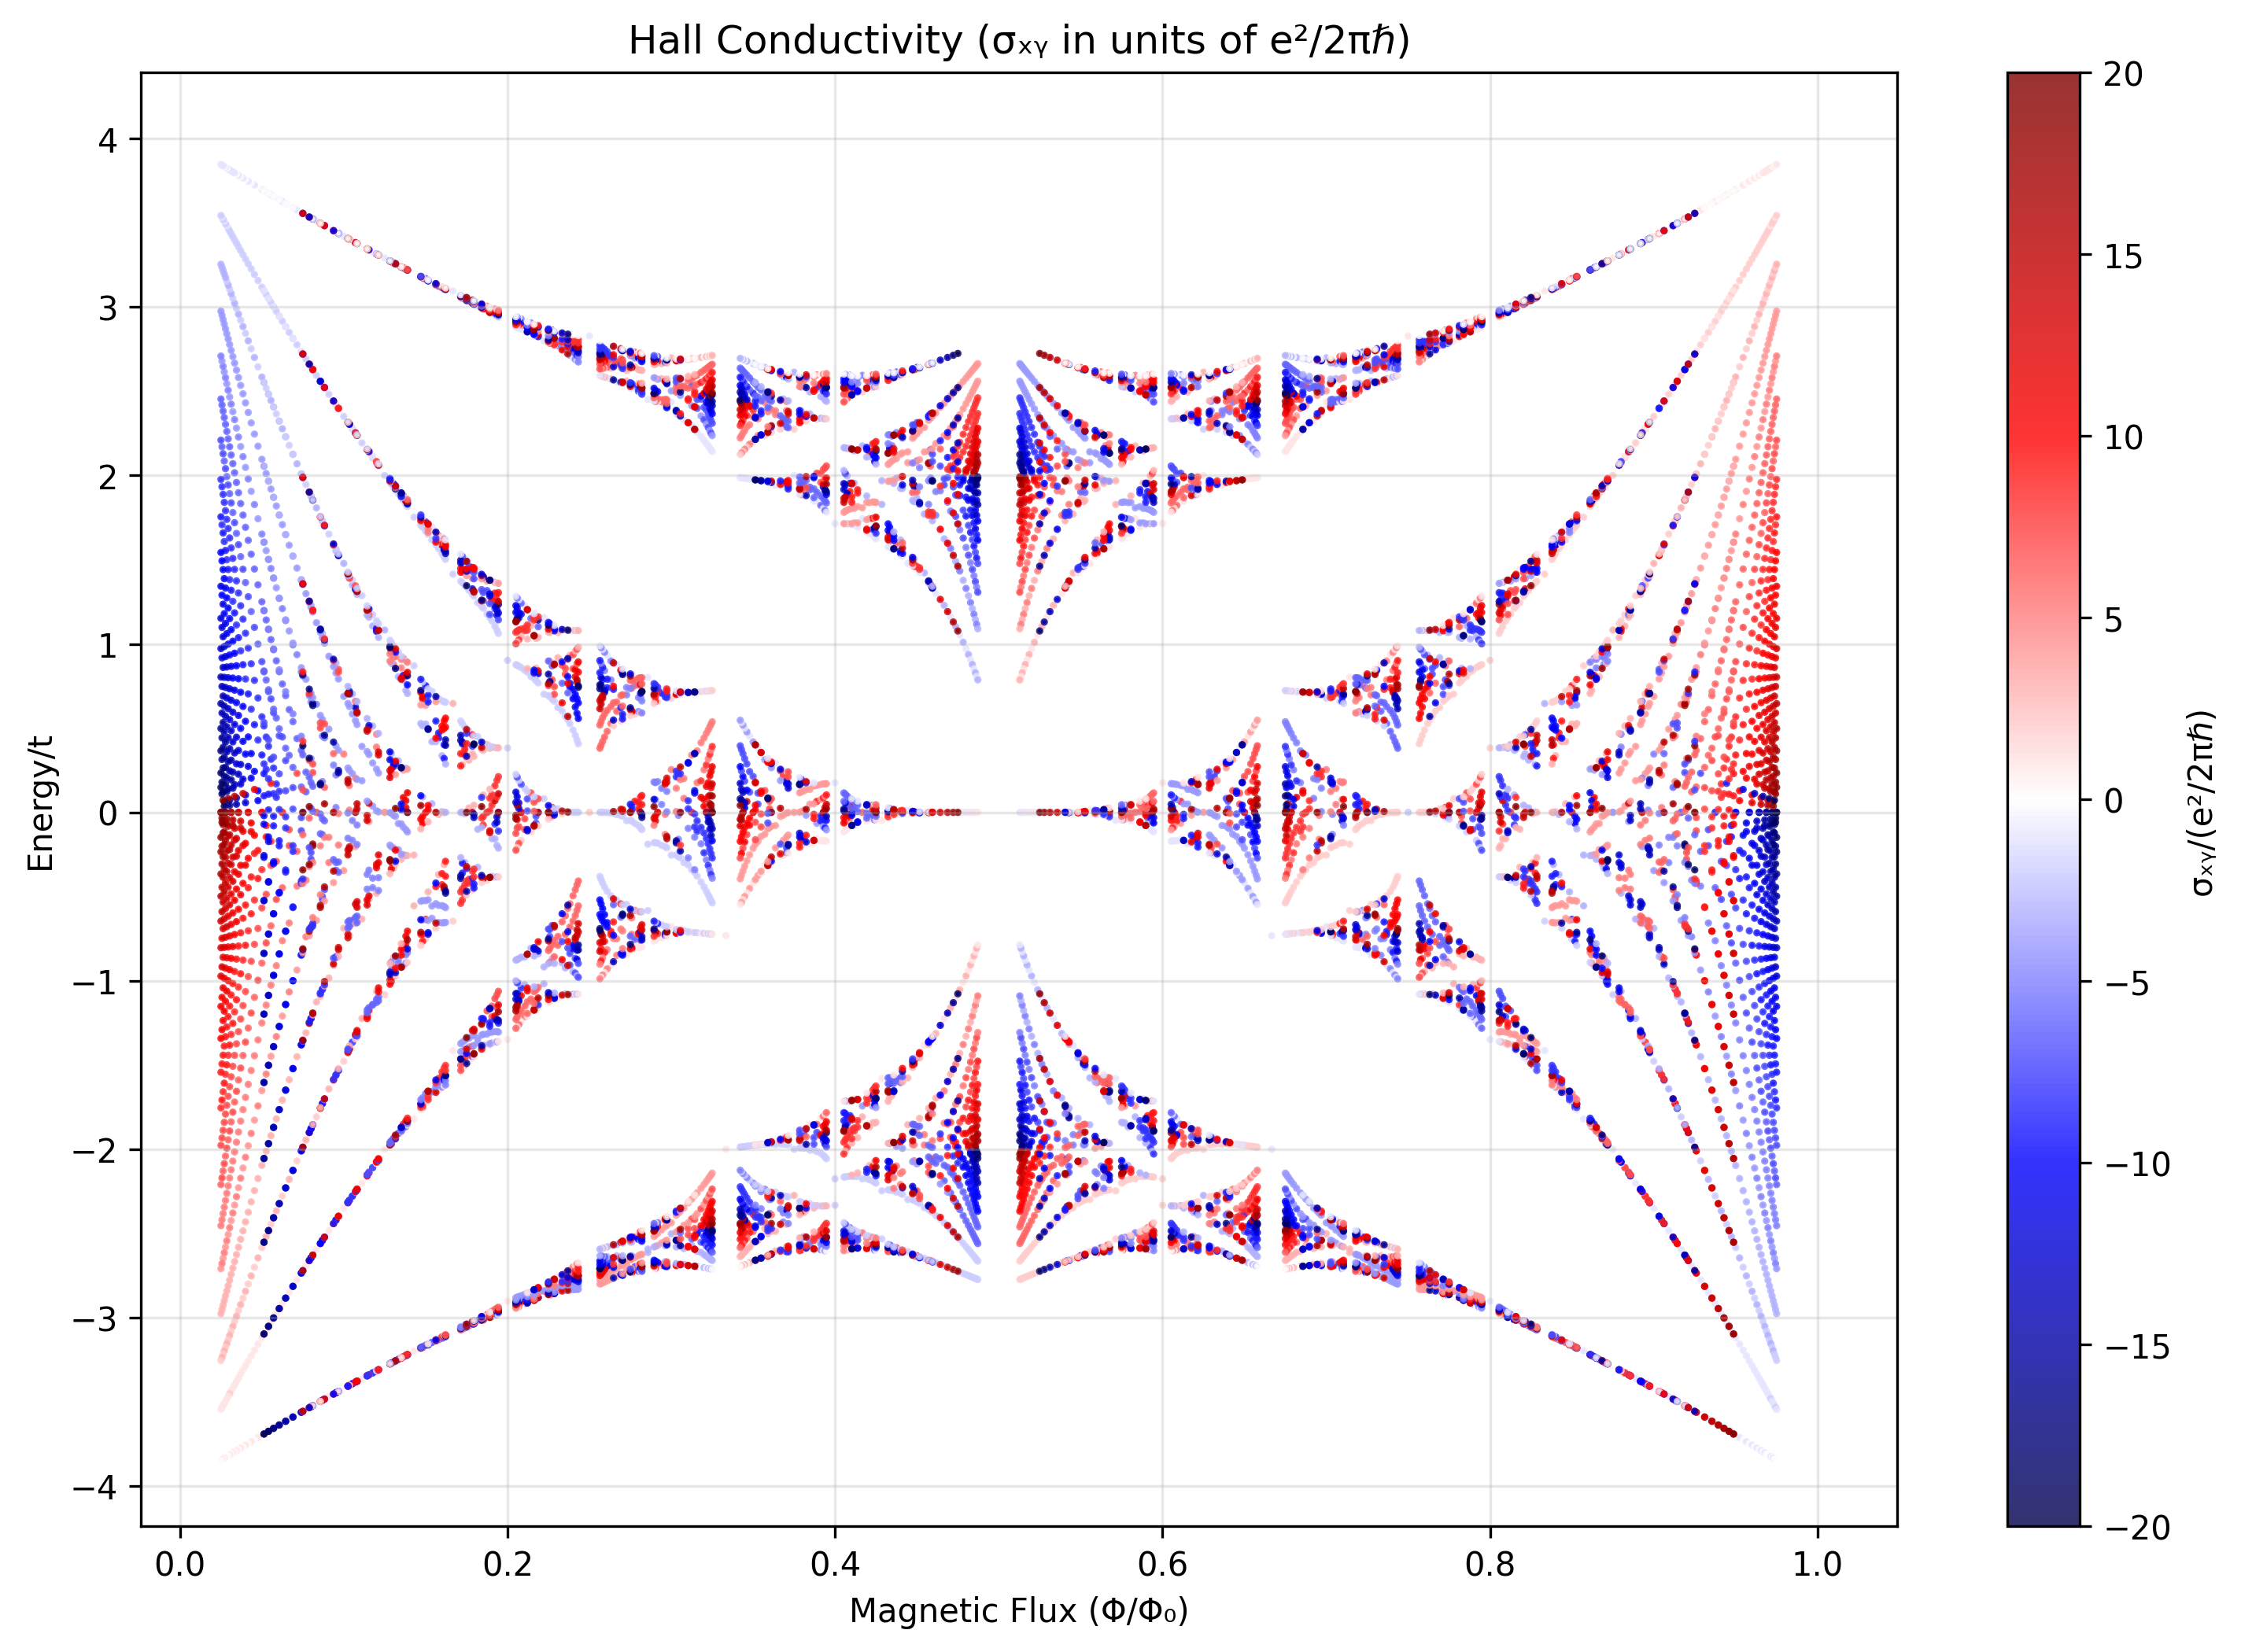

In [8]:
# Computing Hall is slow, so use small q for fast computation 
cdata = compute_butterfly_with_chern(max_q=40)
plot_chern_butterfly(cdata)
plot_hall_conduct(cdata) 

/var/folders/n3/s2srdfnn7fg9nj6jlymgdl5w0000gn/T/ipykernel_80374/196840865.py:168: RuntimeWarning: invalid value encountered in sqrt
  real_energies.append(np.sqrt(i+3))
/var/folders/n3/s2srdfnn7fg9nj6jlymgdl5w0000gn/T/ipykernel_80374/196840865.py:169: RuntimeWarning: invalid value encountered in sqrt
  real_energies.append(-np.sqrt(i+3))


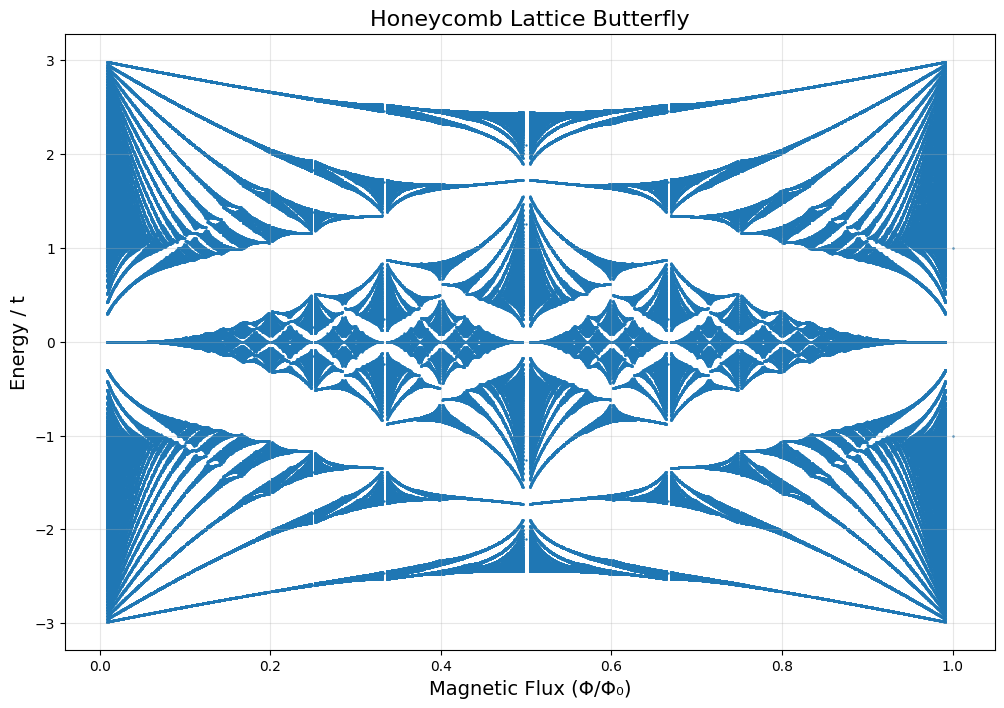

In [9]:
hdata = compute_honeycomb(max_q=120)
plot_honeycomb_butterfly(hdata)

# Topological Phases 

In [10]:
# Filtering conductivities
def get_hall_data(bdata):

    hall_conductivities = []
    flux_grid = []
    energy_grid = []

    for d in bdata:
        hall_cond = compute_hall_conductivity(d['p'], d['q'], d['energy'])
        hall_conductivities.append(hall_cond)
        flux_grid.append(d['flux'])
        energy_grid.append(d['energy'])

    hall_conductivities = np.array(hall_conductivities)
    flux_grid = np.array(flux_grid)
    energy_grid = np.array(energy_grid)

    return flux_grid, energy_grid, hall_conductivities

def filter_by_cmax(flux_vals, energies, hcs, cmax):
    mask = np.abs(hcs) <= cmax
    return flux_vals[mask], energies[mask], hcs[mask]


def plot_hall_colored_gaps(bdata, cmax=5, save_path=None, dpi=300): 

    flux_grid, energy_grid, hcs = get_hall_data(bdata)
    
    flux_grid, energy_grid, hcs = filter_by_cmax(flux_grid, energy_grid, hcs, cmax=cmax)
    
     # Create figure
    fig, ax = plt.subplots(figsize=(12, 8), dpi=dpi)
    #ax.set_facecolor('black')

    scatter3 = plt.scatter(flux_grid, energy_grid, c=hcs,
                          cmap="plasma", s=1.5, alpha=0.8)
    
    ax.set_xlabel('Magnetic Flux (Φ/Φ₀)')
    ax.set_ylabel('Energy/t')
    ax.set_title('Hall Conductivity (σₓᵧ in units of e²/2πℏ)')
    ax.grid(True, alpha=0.3)
    plt.colorbar(scatter3, ax=ax, label='σₓᵧ/(e²/2πℏ)')
    plt.show()
     

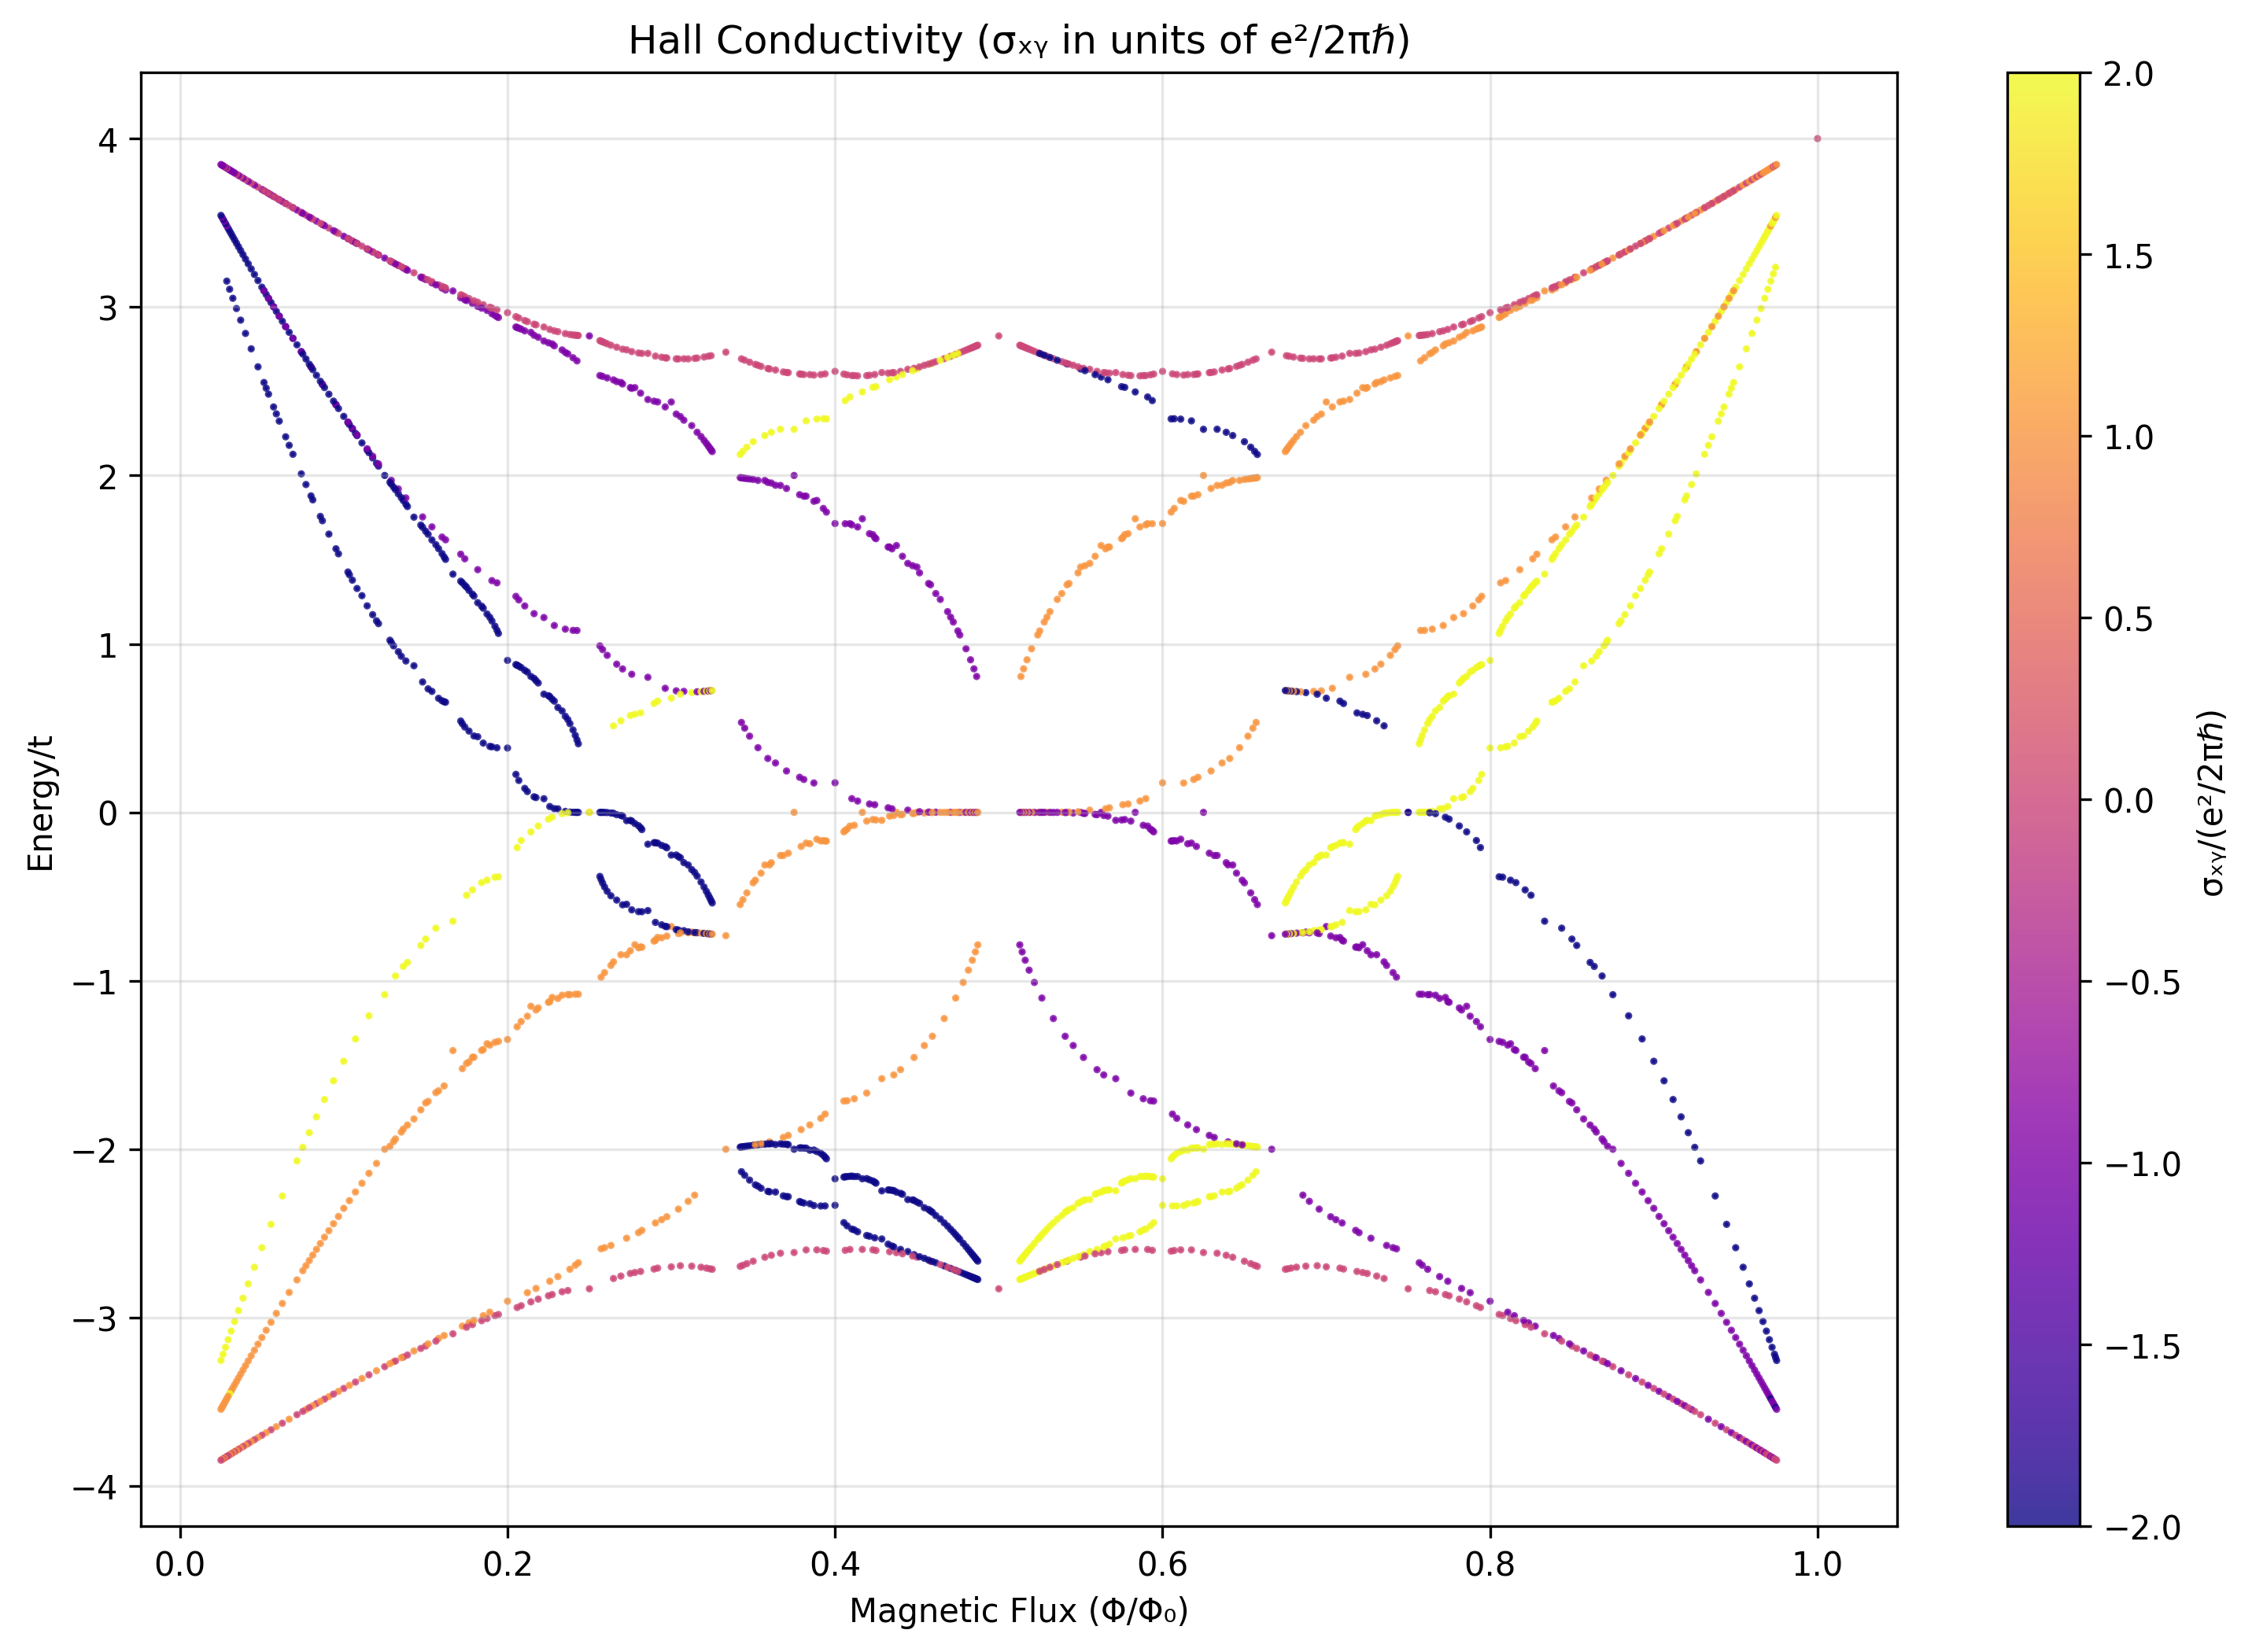

In [11]:
# High q becomes very slow 
tdata = compute_butterfly_with_chern(max_q=40)
plot_hall_colored_gaps(tdata, cmax=2)

In [12]:
# Animating the "fractal wings" of the butterfly by including higher Chern numbers over time
def animate_butterfly_growth(bdata, cs=2, frames=20, interval=300, dpi=200, save=True):
    fig, ax = plt.subplots(figsize=(12, 8), dpi=dpi)
    flux_vals, energies, hcs = get_hall_data(bdata)

    def update(frame, flux_vals, energies, hcs):
        ax.clear()
        cmax = cs+frame;
        
        flux_vals, energies, hcs = filter_by_cmax(flux_vals, energies, hcs, cmax=cmax)
        
        sc = ax.scatter(flux_vals, energies, c=hcs,
                        cmap="plasma", s=1.5, alpha=0.8, vmin=-cmax, vmax=cmax)
        
        ax.set_xlabel('Magnetic Flux (Φ/Φ₀)')
        ax.set_ylabel('Energy/t')
        ax.set_title(f'Hall Conductivity up to cmax={cmax:.2f}')
        ax.grid(True, alpha=0.3)

        # Colorbar handling (refresh each time)
        if not hasattr(ax, '_colorbar'):
            ax._colorbar = fig.colorbar(sc, ax=ax, label='σₓᵧ/(e²/2πℏ)')
        else:
            ax._colorbar.update_normal(sc)

    ani = FuncAnimation(fig, update, frames=frames, fargs=(flux_vals, energies, hcs), interval=interval, repeat=False)

    if save:
        ani.save("fractalwings.mp4", fps=2)
    else:
        plt.show()

In [13]:
# Run animation
tadata = compute_butterfly_with_chern(max_q=40) 

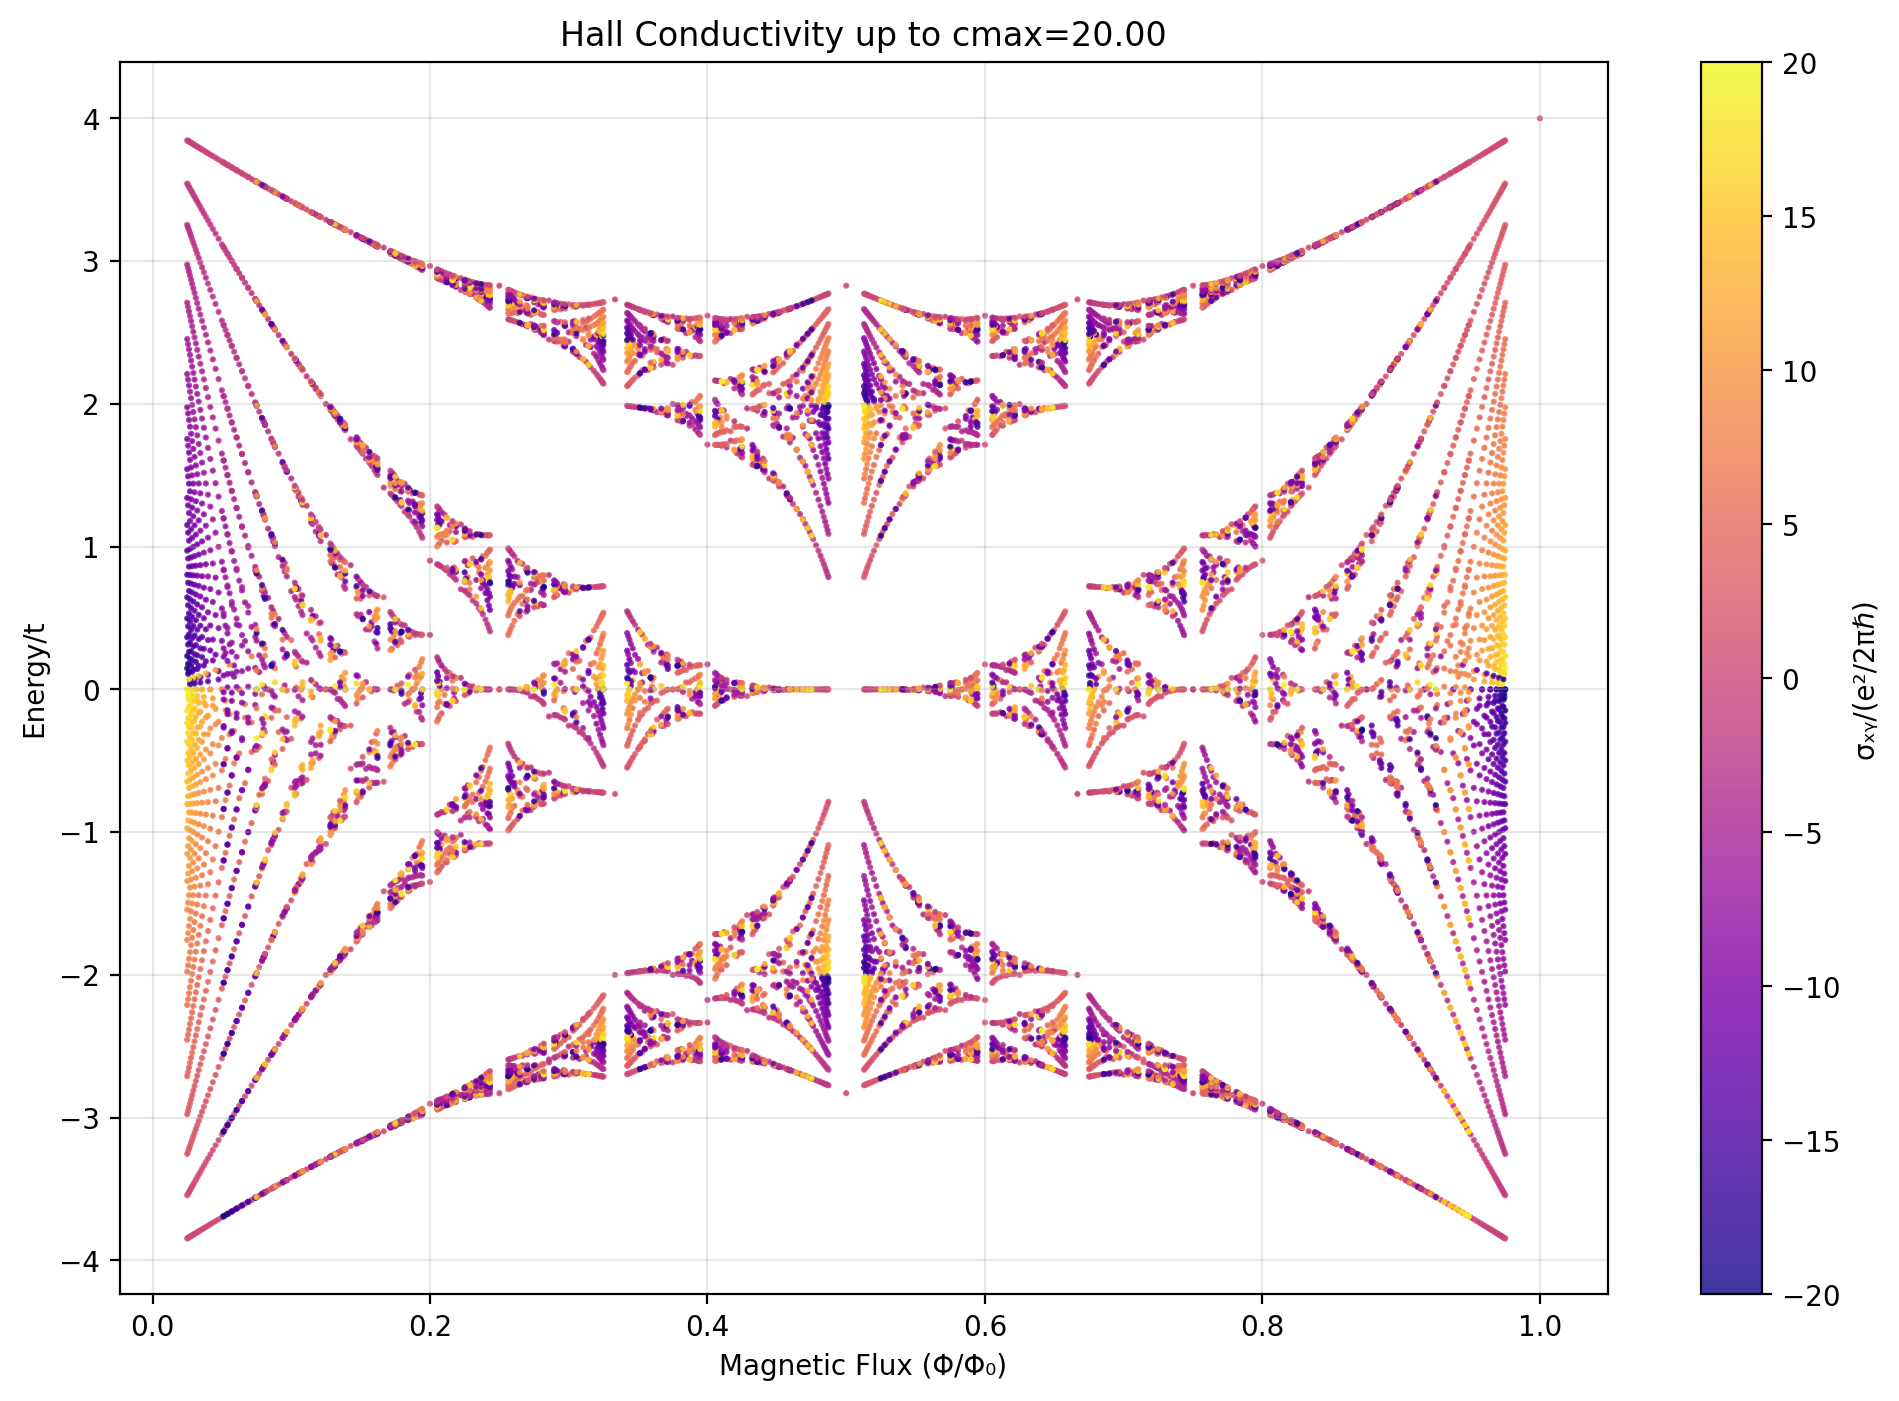

In [14]:
animate_butterfly_growth(tadata, cs=1, frames=20, interval=10)

In [15]:
# Filling in the phase line by line 
def convert_to_df(bdata): 
    df_butterfly = pd.DataFrame(bdata) 
    df_sorted = df_butterfly.sort_values(by=['flux', 'energy']).reset_index(drop=True)
    
    gap_data = []
    
    for flux_val, flux_group in df_sorted.groupby('flux'):
        energies = flux_group['energy'].values
        chern_numbers = flux_group['chern'].values
    
        cumulative_chern = np.cumsum(chern_numbers)
    
        for i in range(len(energies) - 1):
            gap_bottom = energies[i]
            gap_top = energies[i+1]
            gap_mid_energy = (gap_bottom + gap_top) / 2.0
   
            hall_cond_in_gap = cumulative_chern[i]
    
            gap_data.append({
                'flux': flux_val,
                'gap_bottom': gap_bottom,
                'gap_top': gap_top,
                'gap_mid_energy': gap_mid_energy,
                'hall_conductivity': hall_cond_in_gap
            })
    
    df_gap = pd.DataFrame(gap_data)
    return df_gap

def plot_hall_colored_gaps_from_df(df_gap, cmax=2, save_path=None, dpi=600):

    # Filter data based on cmax for coloring
    df_filtered = df_gap[abs(df_gap['hall_conductivity']) <= cmax].copy()

    # Create figure
    fig, ax = plt.subplots(figsize=(12, 8), dpi=dpi)

    # Use a colormap centered at zero
    norm = colors.TwoSlopeNorm(vmin=-cmax, vcenter=0, vmax=cmax)
    cmap = 'plasma' # Or 'RdBu_r'

    # Plot each gap as a vertical line or a narrow rectangle
    for index, row in df_filtered.iterrows():
        flux = row['flux']
        gap_bottom = row['gap_bottom']
        gap_top = row['gap_top']
        hall_cond = row['hall_conductivity']

        # Determine color based on hall_cond
        color = plt.cm.get_cmap(cmap)(norm(hall_cond))

        # Plot a vertical line for the gap
        ax.plot([flux, flux], [gap_bottom, gap_top], color=color, linewidth=0.8, alpha=0.7)

    ax.set_xlabel('Magnetic Flux (Φ/Φ₀)')
    ax.set_ylabel('Energy/t')
    ax.set_title('Hofstadter Butterfly - Hall Conductivity in Gaps (σₓᵧ in units of e²/2πℏ)')
    ax.grid(True, alpha=0.3)

    # Add a color bar manually
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([]) # Dummy array for the scalar mappable
    cbar = fig.colorbar(sm, ax=ax, label='σₓᵧ/(e²/2πℏ)')
    if cmax <= 20: # Add ticks for integer Chern numbers if range is small
         cbar.set_ticks(range(-int(cmax), int(cmax) + 1))


    # Optional save
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight')

    plt.show()

In [16]:
dfdata = compute_butterfly_with_chern(max_q=120) 
df_data = convert_to_df(dfdata)

/var/folders/n3/s2srdfnn7fg9nj6jlymgdl5w0000gn/T/ipykernel_80374/3672066162.py:52: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color = plt.cm.get_cmap(cmap)(norm(hall_cond))


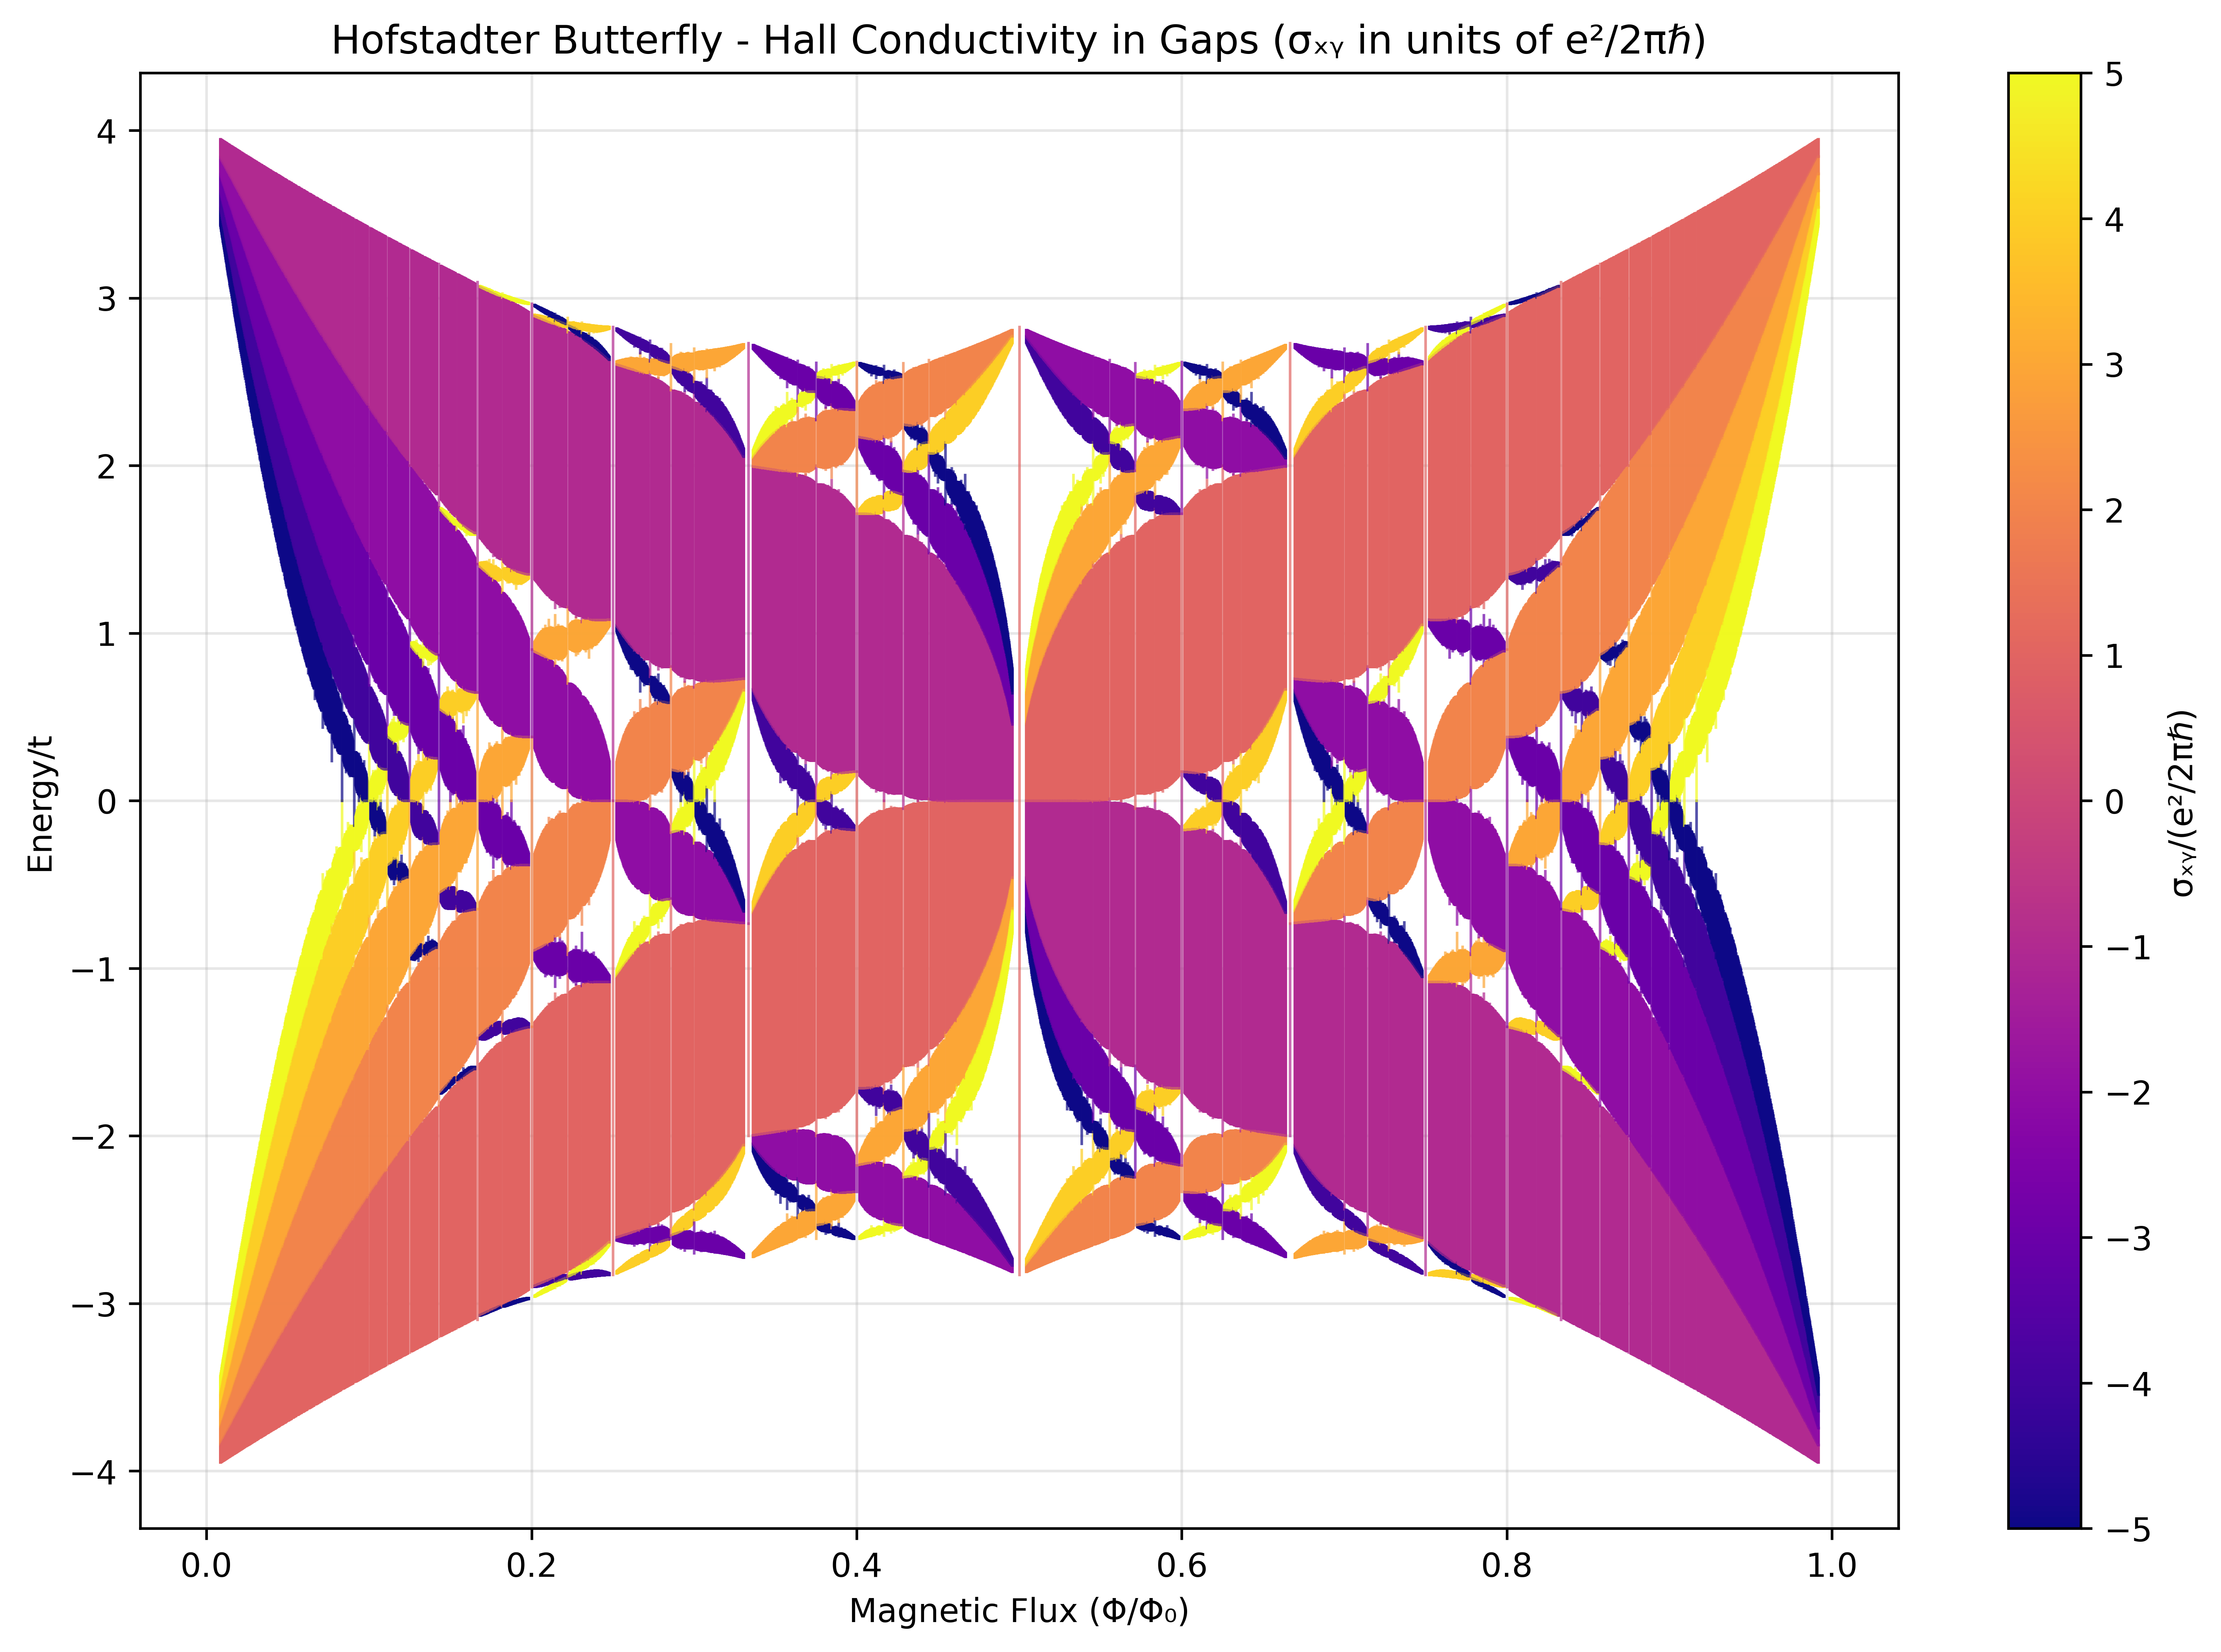

In [17]:
plot_hall_colored_gaps_from_df(df_data, cmax=5)

# Zooming in Animations 

In [27]:
def compute_dynamic_butterfly_with_chern(q_max=30, alpha_min=0.0, alpha_max=1.0):
    """
    Compute Hofstadter butterfly for square lattice with Chern numbers, restricting flux ∈ [alpha_min, alpha_max]
    and q ∈ [q_min, q_max].
    """
    butterfly_data = []
    
    for q in range(1, q_max + 1):
        for p in range(1, q + 1):
            if gcd(p, q) == 1:
                flux = p / q
                if alpha_min <= flux <= alpha_max:
                    H = hofstadter_hamiltonian(p, q)
                    eigenvals = np.sort(eigh(H, eigvals_only=True))
                    chern_numbers, _ = compute_chern_numbers_tknn(p, q)

                    for band_idx, (energy, chern) in enumerate(zip(eigenvals, chern_numbers)):
                        butterfly_data.append({
                            'flux': flux,
                            'energy': energy,
                            'chern': chern,
                            'band': band_idx,
                            'p': p,
                            'q': q
                        })

    return butterfly_data

def compute_dynamic_hexbut(q_max=30, alpha_min=0.0, alpha_max=1.0):
    """
    Compute Hofstadter butterfly for hexagonal lattice similarly to above
    """
    butterfly_data = []
    
    for q in range(1, q_max + 1):
        for p in range(1, q + 1):
            if gcd(p, q) == 1:
                flux = p / q
                if alpha_min <= flux <= alpha_max:
                    H = hexagonal_butterfly_hamiltonian(p, q)
                
                    eigenvals = np.sort(eigh(H, eigvals_only=True))
                    real_energies = []
                    for i in eigenvals: 
                        real_energies.append(np.sqrt(i+3))
                        real_energies.append(-np.sqrt(i+3))
                        
                    
                    # Store data for each band
                    for _, energy in enumerate(real_energies):
                        butterfly_data.append({
                            'flux': flux,
                            'energy': energy,
                        })

    return butterfly_data


In [28]:
# Helper functions for animations 

def interpolate_smooth(start, end, progress, method='log'):
    """
    Multiple interpolation methods for different zoom scenarios.
    """
    if method == 'linear':
        return start + progress * (end - start)
    
    elif method == 'log':
        return interpolate_log(start, end, progress)
    
    elif method == 'smooth_step':
        # Smooth step function (3t² - 2t³)
        smooth_progress = progress * progress * (3 - 2 * progress)
        return start + smooth_progress * (end - start)
    
    elif method == 'smoother_step':
        # Even smoother step function (6t⁵ - 15t⁴ + 10t³)
        smooth_progress = progress**3 * (progress * (progress * 6 - 15) + 10)
        return start + smooth_progress * (end - start)
    
    else:
        raise ValueError(f"Unknown method: {method}")
        
def easing_function(t, easing='ease_in_out'):
    """
    Various easing functions for different animation feels.
    """
    if easing == 'linear':
        return t
    elif easing == 'ease_in':
        return t * t
    elif easing == 'ease_out':
        return 1 - (1 - t)**2
    elif easing == 'ease_in_out':
        if t < 0.5:
            return 2 * t * t 
        else:
            return 1 - 2 * (1 - t)**3
    elif easing == 'ease_in_cubic':
        return t**3
    elif easing == 'ease_out_cubic':
        return 1 - (1 - t)**3
    else:
        return t

def interpolate_log(start, end, progress):
    """
    Logarithmic interpolation for smooth zooming across orders of magnitude.
    """
    if start <= 0 or end <= 0:
        raise ValueError("Both start and end must be positive for log interpolation")
    
    log_start = np.log(start)
    log_end = np.log(end)
    log_current = log_start + progress * (log_end - log_start)
    return np.exp(log_current)



In [29]:
def zoom_butterfly_animation_improved(center_alpha=0.625,
                                    center_energy=0.16,
                                    x_width_start=1.0,
                                    x_width_end=0.01,
                                    y_height_start=6.0,
                                    y_height_end=0.1,
                                    q_max=200,
                                    frames=100,
                                    dpi=200,
                                    easing='ease_out_cubic',
                                    save_path="betterdpbutter.mp4"):
    """
    Zooms into target point (a, e) with desired final resolution and speed
    """
    fig, ax = plt.subplots(figsize=(10, 6), dpi=dpi)
    
    def update(frame):
        ax.clear()
        
        # Apply easing to the progress
        raw_progress = frame / (frames - 1)
        progress = easing_function(raw_progress, easing)
        
        # Logarithmic interpolation for zoom levels
        x_width = interpolate_log(x_width_start, x_width_end, progress)
        y_height = interpolate_log(y_height_start, y_height_end, progress)
        
        # Calculate bounds
    
        # Interpolate centers linearly
        alpha_center = (1 - progress) * 0.5 + progress * center_alpha
        energy_center = (1 - progress) * 0 + progress * center_energy
        
        alpha_min = alpha_center - x_width / 2
        alpha_max = alpha_center + x_width / 2
        energy_min = energy_center - y_height / 2
        energy_max = energy_center + y_height / 2
        
        # Smooth interpolation for resolution (also logarithmic)
        q_cur = int(interpolate_log(60, q_max, progress))
        
        # Recompute data
        data = compute_dynamic_butterfly_with_chern(
            q_max=q_cur,
            alpha_min=alpha_min,
            alpha_max=alpha_max
        )

        filtered = [d for d in data if energy_min <= d['energy'] <= energy_max]
        flux_vals = [d['flux'] for d in filtered]
        energies = [d['energy'] for d in filtered]
        chern_nums = [d['chern'] for d in filtered]

        scatter = ax.scatter(flux_vals, energies, c=chern_nums,
                             cmap='cool', s=0.5, vmin=-5, vmax=5)

        # Colorbar handling (refresh each time)
        if not hasattr(ax, '_colorbar'):
            ax._colorbar = fig.colorbar(scatter, ax=ax, label='Chern Number')
        else:
            ax._colorbar.update_normal(scatter)

        
        print(f"Frame {frame:3d}: Progress {progress:.3f}, "
              f"x_width {x_width:.6f}, y_height {y_height:.3f}, q {q_cur}")
        
        # Plotting code...
        ax.set_xlim(alpha_min, alpha_max)
        ax.set_ylim(energy_min, energy_max)
        ax.set_xlabel('Magnetic Flux (Φ/Φ₀)')
        ax.set_ylabel('Energy / t')
        ax.set_title(f'Zooming into Hofstadter Butterfly (Frame {frame})')
        
        return scatter,
    
    ani = FuncAnimation(fig, update, frames=frames, interval=200, blit=False)
    
    if save_path:
        ani.save(save_path, fps=30, dpi=dpi)
    else:
        plt.show()
    
    return ani


def zoom_hexagonal_butterfly_animation_improved(center_alpha=0.78,
                                    center_energy=0.3,
                                    x_width_start=1.0,
                                    x_width_end=0.01,
                                    y_height_start=6.0,
                                    y_height_end=0.1,
                                    q_max=200,
                                    frames=400,
                                    dpi=200,
                                    easing='ease_out_cubic',
                                    save_path="hexbut.mp4"):
    """
    Improved zoom animation with smooth interpolation and easing.
    """
    fig, ax = plt.subplots(figsize=(10, 6), dpi=dpi)
    
    def update(frame):
        ax.clear()
        
        # Apply easing to the progress
        raw_progress = frame / (frames - 1)
        progress = easing_function(raw_progress, easing)
        
        # Logarithmic interpolation for zoom levels
        x_width = interpolate_log(x_width_start, x_width_end, progress)
        y_height = interpolate_log(y_height_start, y_height_end, progress)
        
        # Calculate bounds
    
        # Interpolate centers linearly
        alpha_center = (1 - progress) * 0.5 + progress * center_alpha
        energy_center = (1 - progress) * 0 + progress * center_energy
        
        alpha_min = alpha_center - x_width / 2
        alpha_max = alpha_center + x_width / 2
        energy_min = energy_center - y_height / 2
        energy_max = energy_center + y_height / 2
        
        # Smooth interpolation for resolution (also logarithmic)
        q_cur = int(interpolate_log(60, q_max, progress))
        
        # Recompute data
        data = compute_dynamic_hexbut(
            q_max=q_cur,
            alpha_min=alpha_min,
            alpha_max=alpha_max
        )

        filtered = [d for d in data if energy_min <= d['energy'] <= energy_max]
        flux_vals = [d['flux'] for d in filtered]
        energies = [d['energy'] for d in filtered]

        # Color just for visual sake no info
        num_points = len(energies)
        colors = np.linspace(0, 1, num_points)
        
        # Create the scatter plot with colors mapped to the dummy index
        scatter = ax.scatter(flux_vals, energies, c=colors, cmap='plasma', s=0.5)
        
        print(f"Frame {frame:3d}: Progress {progress:.3f}, "
              f"x_width {x_width:.6f}, y_height {y_height:.3f}, q {q_cur}")
        
        # Plotting code...
        ax.set_xlim(alpha_min, alpha_max)
        ax.set_ylim(energy_min, energy_max)
        ax.set_xlabel('Magnetic Flux (Φ/Φ₀)')
        ax.set_ylabel('Energy / t')
        ax.set_title(f'Zooming into Hexagonal Butterfly (Frame {frame})')
        
        return scatter,
    
    ani = FuncAnimation(fig, update, frames=frames, interval=200, blit=False)
    
    if save_path:
        ani.save(save_path, fps=30, dpi=dpi)
    else:
        plt.show()
    
    return ani

Frame   0: Progress 0.000, x_width 1.000000, y_height 6.000, q 59
Frame   0: Progress 0.000, x_width 1.000000, y_height 6.000, q 59
Frame   1: Progress 0.010, x_width 0.954993, y_height 5.759, q 60
Frame   2: Progress 0.020, x_width 0.912292, y_height 5.530, q 61
Frame   3: Progress 0.030, x_width 0.871769, y_height 5.311, q 62
Frame   4: Progress 0.040, x_width 0.833300, y_height 5.102, q 62
Frame   5: Progress 0.049, x_width 0.796772, y_height 4.903, q 63
Frame   6: Progress 0.059, x_width 0.762077, y_height 4.712, q 64
Frame   7: Progress 0.069, x_width 0.729113, y_height 4.531, q 65
Frame   8: Progress 0.078, x_width 0.697785, y_height 4.357, q 65
Frame   9: Progress 0.088, x_width 0.668005, y_height 4.191, q 66
Frame  10: Progress 0.097, x_width 0.639687, y_height 4.033, q 67
Frame  11: Progress 0.106, x_width 0.612753, y_height 3.882, q 68
Frame  12: Progress 0.116, x_width 0.587127, y_height 3.737, q 68
Frame  13: Progress 0.125, x_width 0.562741, y_height 3.599, q 69
Frame  14:

Frame   0: Progress 0.000, x_width 1.000000, y_height 6.000, q 59


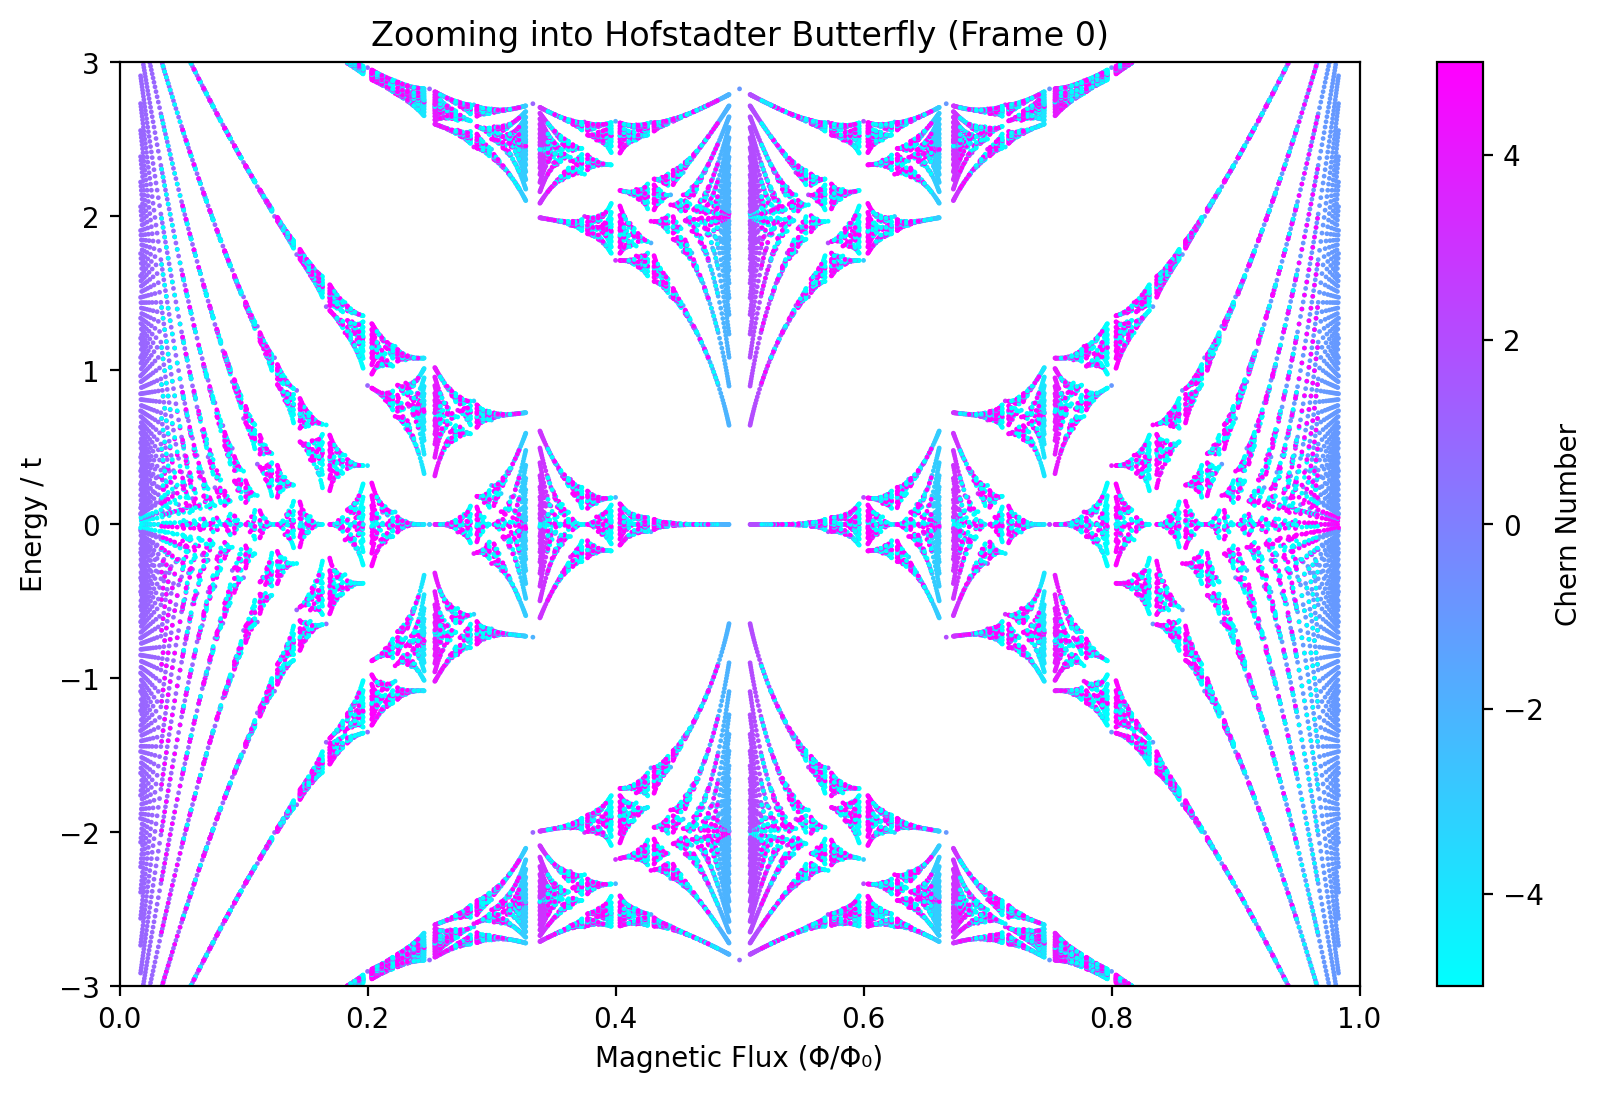

In [30]:
# Running these cells will produce an animation, takes anywhere from 5-10 minutes depending on parameters
zoom_butterfly_animation_improved(center_alpha=(41.0/112),center_energy=0,frames=300,save_path="fzoomsquare.mp4")

In [ ]:
zoom_butterfly_animation_improved(center_alpha=0.625,center_energy=0.16,frames=300,save_path="anotherzoomsquare.mp4")

In [ ]:
zoom_hexagonal_butterfly_animation_improved(center_alpha=0.78,center_energy=0,save_path="zoomhex.mp4")